In [ ]:
import torch

import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# View available fonts
# for font in fm.findSystemFonts(fontpaths = None, fontext = 'ttf'):
#    print(fm.FontProperties(fname = font).get_name())

# Set font properties
matplotlib.rcParams['mathtext.fontset'] = 'stix'
# matplotlib.rcParams['font.family'] = 'Nimbus Roman'
matplotlib.rcParams['font.family'] = 'P052'

# Define target distribution

Mixture of Gaussians (bimodal)

In [60]:
# define properties of distribution in scientific notation
locs = torch.tensor([[-1., 0.], [1., 0.]])
scales = torch.tensor([
    [0.4, 0.8], # in x1 and x2 directions
    [0.6, 0.6]]) # in x1 and x2 directions
mixture_weights = torch.tensor([0.5, 0.5])

# To reproduce the paper
scales = torch.tensor([
    [0.2, 0.2], # in x1 and x2 directions
    [0.2, 0.2]]) # in x1 and x2 directions

In [61]:
def mixture_of_gaussians_logprob(locs, scales, mixture_weights):
    """
    Returns a function that computes the log-probability of a Mixture of Gaussians at given points.
    
    Args:
        locs: Tensor of shape [K, D], where K is the number of Gaussians, D is the dimension.
        scales: Tensor of shape [K, D], standard deviations for each Gaussian.
        mixture_weights: Tensor of shape [K], mixture weights (should sum to 1, but we renormalise).
        
    Returns:
        A function that takes input x of shape [N, D] and returns log-probs [N].
    """
    def logprob(x):
        """
        Computes the log-probability of the Mixture of Gaussians at points x.
        """
        # Extract last dimension 
        D = x.shape[-1]
        
        # Log of normalized mixture probabilities
        log_probs = torch.log(mixture_weights / mixture_weights.sum())  # shape: [K]
        log_probs = log_probs.unsqueeze(0)  # shape: [1, K]
        
        # Compute differences between each x and each component mean
        # x: [N, D], locs: [K, D] -> diff: [N, K, D]
        diff = x.unsqueeze(1) - locs.unsqueeze(0)  # shape: [N, K, D]
        
        # Quadratic term of Gaussian
        quad = -0.5 * torch.sum((diff / scales) ** 2, dim = 2)  # shape: [N, K]
        
        # Log of normalizing constant
        log_norm = -0.5 * D * torch.log(2 * torch.tensor(torch.pi)) \
                   - torch.sum(torch.log(scales), dim = -1)  # shape: [K]
        log_norm = log_norm.unsqueeze(0)  # shape: [1, K]
        
        # Full component log probs
        component_log_probs = log_probs + quad + log_norm  # shape: [N, K]
        
        # Log-sum-exp trick
        max_val, _ = torch.max(component_log_probs, dim = 1, keepdim = True)
        log_sum_exp = max_val + torch.log(torch.sum(torch.exp(component_log_probs - max_val), dim = 1, keepdim = True))
        
        return log_sum_exp.squeeze(1)  # shape: [N]
    
    return logprob

# Create log-probabilty lambda (function object) with our defined properties
logprob = mixture_of_gaussians_logprob(
    locs = locs,
    scales = scales,
    mixture_weights = mixture_weights,
)

In [62]:
grid_res = 100
x_plot = torch.linspace(-2.5, 2.5, grid_res)

XX, YY = torch.meshgrid(x_plot, x_plot, indexing = 'xy')
x_plot = torch.stack([XX, YY], dim = -1) # shape: [grid_res, grid_res, 2]
x_plot_flat = x_plot.view(-1, 2) # shape: [grid_res * grid_res, 2]

# Pass flat (N, D) tensor to logprob function
logp_flat = logprob(x_plot_flat) # shape: [grid_res * grid_res]
logp = logp_flat.reshape(grid_res, grid_res) # shape: [grid_res, grid_res]

# Plot target density

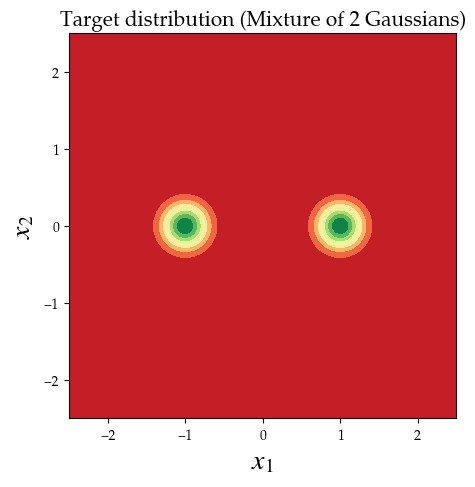

In [63]:
plt.figure(figsize = (5, 5))
plt.contourf(
    x_plot[:, :, 0],
    x_plot[:, :, 1],
    torch.exp(logp), # transform back to probabilities
    cmap = "RdYlGn",
)

# Format plot
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.title('Target distribution (Mixture of 2 Gaussians)', fontsize = 15)
plt.show()

In [ ]:
def eq(lengthscales):
    """
    Squared exponential (RBF) kernel (i.e. eq: Exponentiated Quadratic) with dimension-specific lengthscales (akin to ARD).
    
    Args:
        lengthscales (torch.Tensor): A 1D tensor of lengthscales for each dimension (shape [D]).
    
    Returns:
        kernel (callable): A function that computes the kernel matrix between x and x_.
    """
    def kernel(x):
        """ Calculate the kernel matrix between x and x_ (itself) using the squared exponential kernel. We define the function like this - with one input - for the to be able to apply the functional jacobian from torch"""
        
        # Create a version of x to use as the "reference" set in the kernel (self-referential)
        x_ = x.detach().clone().requires_grad_(False)  # shape: [N, D]

        # Compute pairwise differences between all points in x and x_ via broadcasting
        # Resulting shape: [N, N, D] where N = x.shape[0], thus also N = x_.shape[0]
        diff = x[:, None, :] - x_[None, :, :]

        # Normalize differences by lengthscales, then square and sum across dimensions
        # This computes the squared Mahalanobis distance
        quad_scaled = torch.sum((diff / lengthscales) ** 2, dim = 2)  # shape: [N, N]

        # Apply the exponential to get the RBF kernel values
        exp = torch.exp(-0.5 * quad_scaled)  # shape: [N, N]

        return exp  # Kernel matrix between x and x_
    
    return kernel

def svgd_grad(x, logprob, kernel):
    """
    Compute the Stein Variational Gradient for a set of particles.

    Args:
        x (torch.Tensor): Particles, shape [N, D], where N is the number of particles and D is the dimensionality.
        logprob (callable): Function that returns log-probability for a batch of inputs.
        kernel (callable): Kernel function that takes two inputs (x, x_) and returns a [N, N] kernel matrix.

    Returns:
        torch.Tensor: SVGD update directions, shape [N, D]
    """
    # Clone x and ensure gradients are tracked
    x = x.detach().clone().requires_grad_(True)

    # Extract number of particles for normalisation
    N = x.shape[0]

    # Compute the kernel matrix K between particles (pair-wise)
    k = kernel(x)  # shape: [N, N]

    ### ATTRACTIVE FORCE (CONSENSUS) ###
    # Compute the gradient of logp w.r.t. particles x
    # In which direction does the log-probability increase?
    # Jacobian outputs [N, N, D] where only the diagonal of [N, N] is non-zero. Flip dims to get [N, D]
    dlogp = torch.autograd.functional.jacobian(logprob, x).diagonal(dim1 = 0, dim2 = 1).permute(1, 0)  # shape: [N, D]

    ### REPULSIVE FORCE (DIVERSITY) ###
    # Compute the gradient of the kernel matrix w.r.t. x (∇_{x} k(x, x′))
    # The Jacobian has shape [output_shape + input_shape] → [N, N] from kernel + [N, D] from x → [N, N, N, D]
    jac = torch.autograd.functional.jacobian(kernel, x) # shape: [N, N, N, D]
    dk = jac.diagonal(dim1 = 0, dim2 = 2).permute(2, 0, 1).sum(dim = 1) # final shape: [N, D]
    # same as tf.reduce_sum(dk, axis=0) which sums the first axis entries

    # Compute the SVGD update direction
    # First term: attractive force (consensus), second term: repulsive force (diversity)
    svg = (torch.matmul(k, dlogp) - dk) / N  # shape: [N, D]

    return svg, k, dlogp, dk

In [ ]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x_initial = 0.2 * torch.randn(num_particles, 2)

# Create EQ kernel
eq_scales = torch.tensor([0.2, 0.2])
kernel = eq(eq_scales)

# this is epsilon in the original paper
stepsize = 0.1 # 1e-1 as in notebook

# svg is phi in the original paper
svg, k, dlogp, dk = svgd_grad(x = x_initial, logprob = logprob, kernel = kernel)

In [137]:
k[0:5, 0:5], k[0:5, 0:5].shape

(tensor([[1.0000, 0.0632, 0.0015, 0.0058, 0.1615],
         [0.0632, 1.0000, 0.2694, 0.4606, 0.8141],
         [0.0015, 0.2694, 1.0000, 0.0692, 0.2239],
         [0.0058, 0.4606, 0.0692, 1.0000, 0.1738],
         [0.1615, 0.8141, 0.2239, 0.1738, 1.0000]], grad_fn=<SliceBackward0>),
 torch.Size([5, 5]))

# Show what is happening at step 1

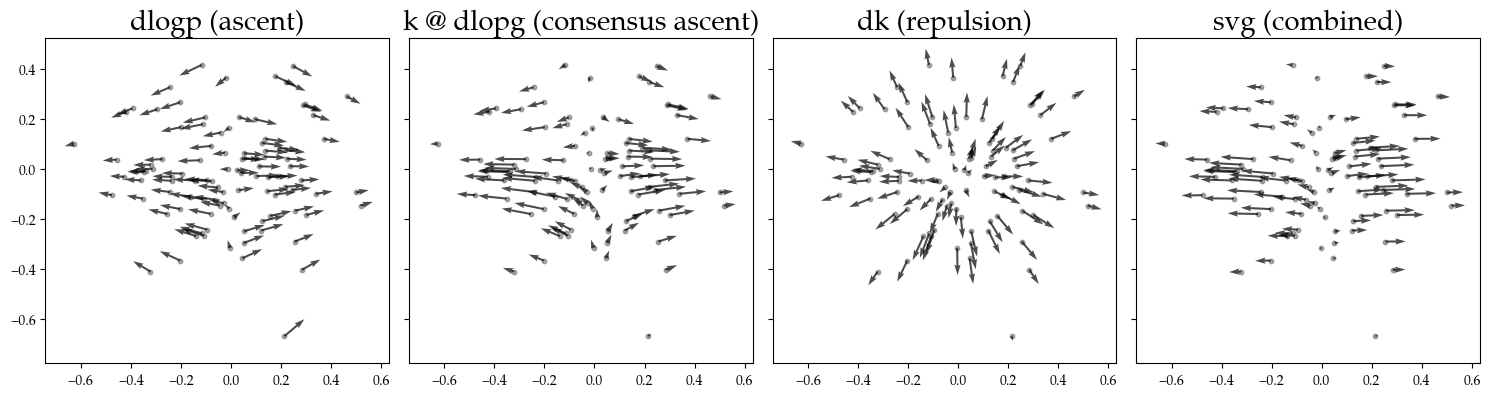

In [ ]:
import matplotlib.pyplot as plt

# Detach everything for plotting
x_np = x_initial.detach().numpy()
dlogp_np = dlogp.detach().numpy() / num_particles # normalise by number of particles
dlogp_np = dlogp.detach().numpy()
k_dlogp_np = (k @ dlogp).detach().numpy() / num_particles
dk_np = - dk.detach().numpy() / num_particles # negate
svgd_np = svg.detach().numpy()

# Limits
buffer_ratio = 0.1

x_min, x_max = x_np[:, 0].min(), x_np[:, 0].max()
y_min, y_max = x_np[:, 1].min(), x_np[:, 1].max()

x_range = x_max - x_min
y_range = y_max - y_min

x_lim = (x_min - buffer_ratio * x_range, x_max + buffer_ratio * x_range)
y_lim = (y_min - buffer_ratio * y_range, y_max + buffer_ratio * y_range)


fig, axes = plt.subplots(1, 4, figsize = (15, 5), sharex = True, sharey = True)

titles = ["dlogp (ascent)", "k @ dlopg (consensus ascent)", "dk (repulsion)", "svg (combined)"]
vectors = [dlogp_np, k_dlogp_np, dk_np, svgd_np]

for ax, title, vec in zip(axes, titles, vectors):
    ax.scatter(x_np[:, 0], x_np[:, 1], color = 'gray', s = 10, label = 'Particles', alpha = 0.7)
    ax.quiver(x_np[:, 0], x_np[:, 1], vec[:, 0], vec[:, 1],
              angles = 'xy', scale_units = 'xy', color = 'black', alpha = 0.7)
    ax.set_title(title, fontsize = 20)
    ax.set_aspect('equal', adjustable = 'box')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

plt.tight_layout()
plt.show()

## Intuition of k @ dlogp

- dlogp[j] is the "suggested direction" by particle j.
- k(x_i, x_j) is the influence of particle j on i.
- So K @ dlogp is a **weighted average of other particles’ gradients**, where nearby particles (in kernel space) contribute more.
- This **smoothes out** the gradient vectors
- Consensus ascent — particle i moves in a direction that aligns with the shared belief of nearby particles.
- ascent: the direction of increase in log-probability

## Intuition of dk

- balance exploration (dk) and exploitation
- repulsion

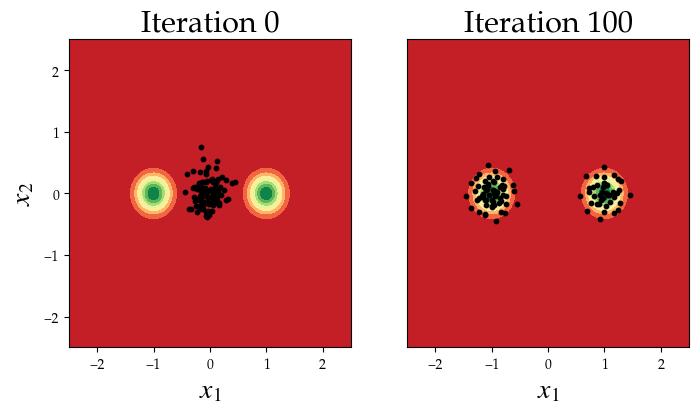

In [141]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x = 0.2 * torch.randn(num_particles, 2)

# Create EQ kernel
eq_scales = torch.tensor([0.2, 0.2])
kernel = eq(eq_scales)

stepsize = 0.1 # 1e-1 as in notebook
num_steps = 100

plt.figure(figsize = (8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contourf(
            x_plot[:, :, 0],
            x_plot[:, :, 1],
            torch.exp(logp),
            cmap = "RdYlGn",
        )
        
        plt.xlabel('$x_1$', fontsize = 20)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize = 20)
        
        plt.title(f'Iteration {i}', fontsize = 22)
    
    # Compute Stein variational gradient
    svg, _, _, _ = svgd_grad(x, logprob = logprob, kernel = kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.detach()
        
plt.show()

# Replicate failure mode 

If we initialise the particle on one mode, the other mode migt not be reached ever. (Stuck in local optimum)

[Random walks book](https://github.com/stratisMarkou/random-walks/blob/master/random-walks/book/papers/svgd/svgd.ipynb)

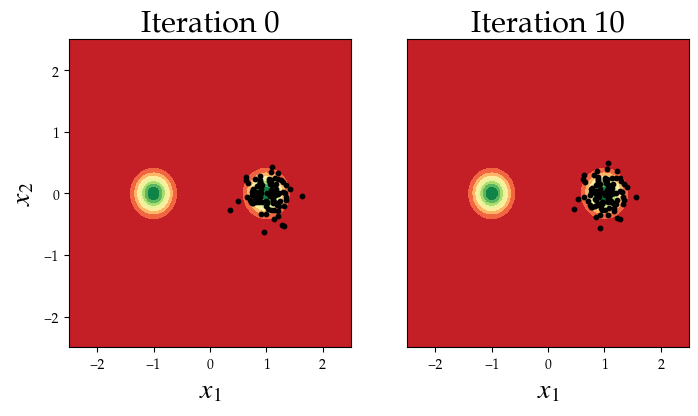

In [142]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x = 0.2 * torch.randn(num_particles, 2)
### THIS IS THE ONLY CHANGE
x = x - torch.tensor([[-1., 0]]) # shift particles to the right, on top of one of the modes

# Create EQ kernel
eq_scales = torch.tensor([0.2, 0.2])
kernel = eq(eq_scales)

stepsize = 0.1 # 1e-1 as in notebook
num_steps = 10

plt.figure(figsize = (8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contourf(
            x_plot[:, :, 0],
            x_plot[:, :, 1],
            torch.exp(logp),
            cmap = "RdYlGn",
        )
        
        plt.xlabel('$x_1$', fontsize = 20)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize = 20)
        
        plt.title(f'Iteration {i}', fontsize = 22)
    
    # Compute Stein variational gradient
    svg, _, _, _ = svgd_grad(x, logprob = logprob, kernel = kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.detach()
        
plt.show()

## Showcase how it works with a random (not random normal) initialisation

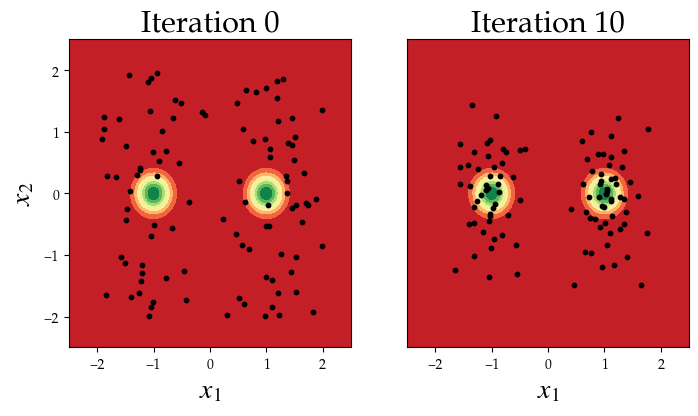

In [146]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
### THIS IS THE ONLY CHANGE: repeat with uniformly distributed particles
x = torch.rand(num_particles, 2) * 4 - 2

# Create EQ kernel
eq_scales = torch.tensor([0.2, 0.2])
kernel = eq(eq_scales)

stepsize = 0.1 # 1e-1 as in notebook
num_steps = 10

plt.figure(figsize = (8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contourf(
            x_plot[:, :, 0],
            x_plot[:, :, 1],
            torch.exp(logp),
            cmap = "RdYlGn",
        )
        
        plt.xlabel('$x_1$', fontsize = 20)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize = 20)
        
        plt.title(f'Iteration {i}', fontsize = 22)
    
    # Compute Stein variational gradient
    svg, _, _, _ = svgd_grad(x, logprob = logprob, kernel = kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.detach()
        
plt.show()

# Repeat with adaptive lengthscale as in paper

RBF kernel definition:
- With lengthscale l: $k(x, x') = \exp\left(-\frac{1}{2\ell^2} \|x - x'\|_2^2\right)$
- With bandwidth h: $k(x, x') = \exp\left(-\frac{1}{h} \|x - x'\|_2^2\right), \quad \text{where } h = 2\ell^2$
    - $\|x - x'\|_2$ The subscript 2 means we are using the standard L2 Euclidean norm (this is the default usually).

Adaptive bandwidth:
- $h = med^2 / \log{n}$, where med is the median of the pairwise distance between the current points. (not the squared pairwise distances)


In [ ]:
# Kernel function with adaptive lengthscale
def kernel(x):
    """ Calculate the kernel matrix between x and x_ (itself) using the squared exponential kernel. We define the function like this - with one input - for the to be able to apply the functional jacobian from torch"""
    
    # Create a version of x to use as the "reference" set in the kernel (self-referential)
    x_ = x.detach().clone().requires_grad_(False)  # shape: [N, D]

    # Compute pairwise differences between all points in x and x_ via broadcasting
    # Resulting shape: [N, N, D] where N = x.shape[0], thus also N = x_.shape[0]
    diff = x[:, None, :] - x_[None, :, :]
    sq_dist = (diff ** 2).sum(dim = 2) # no ARD

    # Normalize differences by lengthscales, then square and sum across dimensions
    # This computes the squared Mahalanobis distance
    # bandwidth (h) = 2 * lengthscales ** 2
    h = torch.median(sq_dist.reshape(-1)).item() # median across all dims
    h = 0.5 * h / torch.log(torch.tensor(x.shape[0] + 1, dtype = torch.float32))
    h = torch.sqrt(h)

    sq_dist_scaled = sq_dist / h**2 / 2 # shape: [N, N]. As in original code?! not quite consistent

    # Apply the exponential to get the RBF kernel values
    exp = torch.exp(- sq_dist_scaled)  # shape: [N, N]

    return exp  # Kernel matrix between x and x_

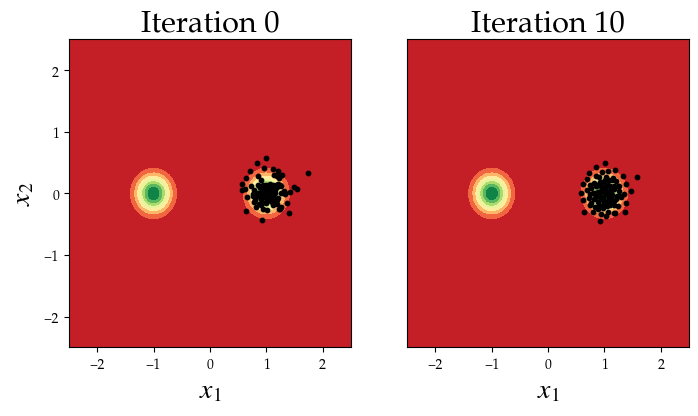

In [167]:
### INITIALISE PARTICLES ###
# Number of particles to simulate
num_particles = 100

# Initial positions of particles
x = 0.2 * torch.randn(num_particles, 2)
### THIS IS THE ONLY CHANGE
x = x - torch.tensor([[-1., 0]]) # shift particles to the right, on top of one of the modes

### Use adpative kernel function

stepsize = 0.1 # 1e-1 as in notebook
num_steps = 10

plt.figure(figsize = (8, 4))

for i in range(num_steps + 1):
    
    # Plot 0th iteration and last iteration
    if i in [0, num_steps]:
        
        # Choose appropriate subplot
        plt.subplot(1, 2, (i > 0) + 1)
        
        # Plot particles and probabilities
        plt.scatter(x[:, 0], x[:, 1], zorder=2, c='k', s=10)
        plt.contourf(
            x_plot[:, :, 0],
            x_plot[:, :, 1],
            torch.exp(logp),
            cmap = "RdYlGn",
        )
        
        plt.xlabel('$x_1$', fontsize = 20)
        
        if i > 0:
            plt.yticks([])
            
        else:
            plt.ylabel('$x_2$', fontsize = 20)
        
        plt.title(f'Iteration {i}', fontsize = 22)
    
    # Compute Stein variational gradient
    svg, _, _, _ = svgd_grad(x, logprob = logprob, kernel = kernel)
    
    # Adapt particle locations using the SVG
    x = x + stepsize * svg.detach()
        
plt.show()